### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [ ]:
import os
import platform

# Descargar el dataset si no existe
if not os.path.exists("datasets_2"):
    if not os.path.exists("datasets.zip"):
        !wget -O datasets_2.zip https://github.com/Nico-Werner/ceia-procesamiento_del_lenguaje_natural/raw/main/datasets_2.zip
    !unzip -q datasets_2.zip
else:
    print("El dataset ya se encuentra descargado.")

# Listar archivos disponibles
print("Archivos disponibles en datasets:")
print(os.listdir("datasets"))

--2025-06-19 03:22:11--  https://github.com/Nico-Werner/ceia-procesamiento_del_lenguaje_natural/raw/main/datasets_2.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Nico-Werner/ceia-procesamiento_del_lenguaje_natural/main/datasets_2.zip [following]
--2025-06-19 03:22:11--  https://raw.githubusercontent.com/Nico-Werner/ceia-procesamiento_del_lenguaje_natural/main/datasets_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2561470 (2.4M) [application/zip]
Saving to: ‘datasets_2.zip’

datasets_2.zip      100%[===================>]   2.44M  --.-KB/s    in 0.04s   

2025-06-19 03:22:12 (69.8 MB

In [ ]:
corpus_file = 'frankenstein.txt'

with open(f'datasets/{corpus_file}', encoding='utf-8') as f:
    text = f.read().lower()
print(text[:1000])  # Mostrar parte del texto

the project gutenberg ebook of frankenstein; or, the modern prometheus
    
this ebook is for the use of anyone anywhere in the united states and
most other parts of the world at no cost and with almost no restrictions
whatsoever. you may copy it, give it away or re-use it under the terms
of the project gutenberg license included with this ebook or online
at www.gutenberg.org. if you are not located in the united states,
you will have to check the laws of the country where you are located
before using this ebook.

title: frankenstein; or, the modern prometheus

author: mary wollstonecraft shelley

release date: october 1, 1993 [ebook #84]
                most recently updated: november 5, 2024

language: english

credits: judith boss, christy phillips, lynn hanninen and david meltzer. html version by al haines.
        further corrections by menno de leeuw.


*** start of the project gutenberg ebook frankenstein; or, the modern prometheus ***

frankenstein;

or, the modern prometheus



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Tokenizador por palabras
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
total_words = len(tokenizer.word_index) + 1

# Crear secuencias de entrada (n-gramas)
input_sequences = []
for line in text.split('\n'):
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

# Padding de secuencias
max_seq_len = max([len(seq) for seq in input_sequences])
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len, padding='pre')

# Separar en X (contexto) e y (palabra objetivo)
X = input_sequences[:, :-1]
y = input_sequences[:, -1]
y = np.eye(total_words)[y]

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, SimpleRNN, Dense

# Usamos el modelo lstm
def get_model(model_type='lstm'):
    model = Sequential()
    model.add(Embedding(total_words, 100))
    if model_type == 'lstm':
        model.add(LSTM(150))
    elif model_type == 'gru':
        model.add(GRU(150))
    else:
        model.add(SimpleRNN(150))
    model.add(Dense(total_words, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

model = get_model('lstm')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento con monitoreo de perplexity:

In [ ]:
import tensorflow as tf

# Callback para mostrar perplejidad en validación
class PerplexityCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        perplexity = np.exp(val_loss) if val_loss else None
        print(f"\nPerplexity: {perplexity:.2f}")

callbacks = [PerplexityCallback()]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=128,
    callbacks=callbacks
)

Epoch 1/20
505/506 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0522 - loss: 7.0067
Perplexity: 721.90
506/506 ━━━━━━━━━━━━━━━━━━━━ 25s 46ms/step - accuracy: 0.0522 - loss: 7.0054 - val_accuracy: 0.0564 - val_loss: 6.5819
Epoch 2/20
505/506 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0595 - loss: 6.4606
Perplexity: 620.72
506/506 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.0595 - loss: 6.4605 - val_accuracy: 0.0726 - val_loss: 6.4309
Epoch 3/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.0720 - loss: 6.3338
Perplexity: 574.90
506/506 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.0720 - loss: 6.3338 - val_accuracy: 0.0749 - val_loss: 6.3542
Epoch 4/20
505/506 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.0789 - loss: 6.2503
Perplexity: 533.57
506/506 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.0789 - loss: 6.2502 - val_accuracy: 0.0816 - val_loss: 6.2796
Epoch 5/20
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.0911 - loss: 6.1355
Perplexity: 4

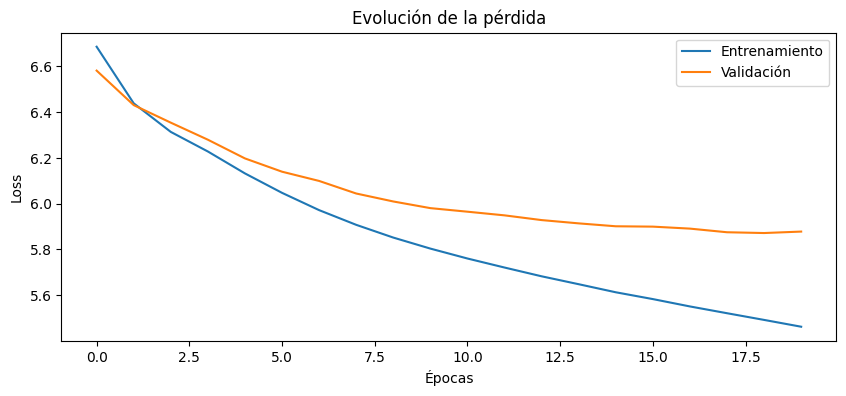

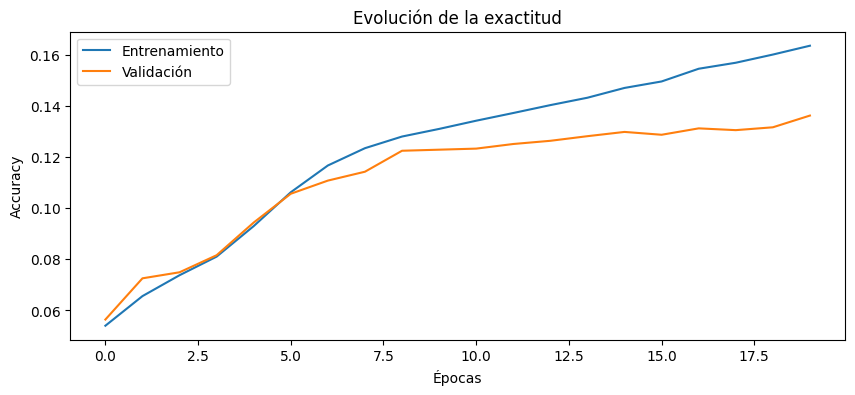

In [ ]:
import matplotlib.pyplot as plt

# Graficar loss (pérdida)
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Graficar accuracy
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución de la exactitud')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

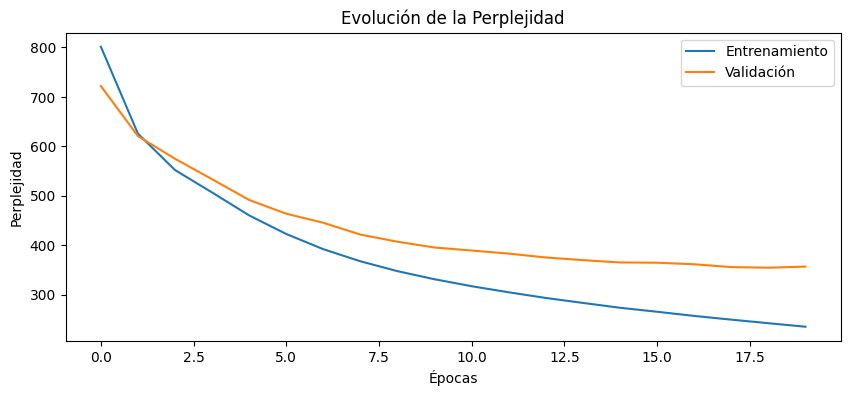

In [ ]:
import numpy as np

perplexity_train = np.exp(history.history['loss'])
perplexity_val = np.exp(history.history['val_loss'])

plt.figure(figsize=(10,4))
plt.plot(perplexity_train, label='Entrenamiento')
plt.plot(perplexity_val, label='Validación')
plt.title('Evolución de la Perplejidad')
plt.xlabel('Épocas')
plt.ylabel('Perplejidad')
plt.legend()
plt.show()

### Modelos RNN
Ahora probamos la generacion de texto con distintas implementaciones

#### Greedy Search

In [ ]:
def generate_text_greedy(seed_text, num_words, model, max_seq_len):
    for _ in range(num_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ''
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

print(generate_text_greedy("it was a dark", 10, model, max_seq_len))

it was a dark of the same time i was not to be the


#### Beam Search deterministico

In [ ]:
def generate_text_beam_search(seed_text, num_words, model, max_seq_len, beam_width=3):
    sequences = [[seed_text, 1.0]]
    for _ in range(num_words):
        all_candidates = []
        for seq, score in sequences:
            token_list = tokenizer.texts_to_sequences([seq])[0]
            token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
            preds = model.predict(token_list, verbose=0)[0]
            # Obtener los beam_width tokens más probables
            top_indices = preds.argsort()[-beam_width:][::-1]
            for idx in top_indices:
                word = tokenizer.index_word.get(idx)
                if word:
                    candidate = [seq + ' ' + word, score * preds[idx]]
                    all_candidates.append(candidate)
        # Ordenamos y nos quedamos con los mejores beam_width
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_width]
    return sequences[0][0]

print(generate_text_beam_search("it was a dark", 10, model, max_seq_len, beam_width=3))

it was a dark of which i was not to be the most of


#### Beam Search estocastico

In [ ]:
def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def generate_text_beam_search_stochastic(seed_text, num_words, model, max_seq_len, beam_width=3, temperature=1.0):
    sequences = [[seed_text, 1.0]]
    for _ in range(num_words):
        all_candidates = []
        for seq, score in sequences:
            token_list = tokenizer.texts_to_sequences([seq])[0]
            token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding='pre')
            preds = model.predict(token_list, verbose=0)[0]
            # Muestreo estocástico sobre los beam_width más probables
            top_indices = preds.argsort()[-beam_width:][::-1]
            top_preds = preds[top_indices]
            idx = top_indices[sample_with_temperature(top_preds, temperature)]
            word = tokenizer.index_word.get(idx)
            if word:
                candidate = [seq + ' ' + word, score * preds[idx]]
                all_candidates.append(candidate)
        # Nos quedamos con los mejores beam_width
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_width]
    return sequences[0][0]

print(generate_text_beam_search_stochastic("it was a dark", 10, model, max_seq_len, beam_width=3, temperature=0.8))
print(generate_text_beam_search_stochastic("it was a dark", 10, model, max_seq_len, beam_width=1, temperature=0.2))
print(generate_text_beam_search_stochastic("it was a dark", 10, model, max_seq_len, beam_width=3, temperature=0.5))
print(generate_text_beam_search_stochastic("it was a dark", 10, model, max_seq_len, beam_width=3, temperature=0.7))
print(generate_text_beam_search_stochastic("it was a dark", 10, model, max_seq_len, beam_width=3, temperature=0.9))

it was a dark navigators—there extinguish resist resist unworthiness adventurer appetite uncommonly height antipathy
it was a dark bud bud hurry delight fixing playfellows hellish invader earliest delayed
it was a dark bud navigators—there extinguish wrap rushed eastern regulated pleasant payments reasons
it was a dark navigators—there extinguish resist consecrate rushed listener’s bustle north temper compassionated
it was a dark navigators—there situated sledges extinguish delight fixing unfortunate unworthiness pathetic pathetic


### Conclusion
Primero podemos ver que el modelo aprende patrones del lenguaje de Frankenstein, pero su capacidad de generalizacion y creatividad está limitada por el tamaño de la red y la cantidad de datos. La perplejidad final en validación es considerablemente menor que al inicio, reflejando una mejor capacidad del modelo para predecir la siguiente palabra.

Luego, aplicando la generacion de texto pudimos ver que con Greedy search la generacion se torna muy predecible, monotona y repetitiva. Con beam search determinístico hay algo más de diversidad, pero aun no tan abierto a otras cosas. Y con Beam search estocástico, aplicando temperatura pusimos ver que aca, jugando con la temperatura y el beam_width hubo generacion de texto más creativa y diversa.